In [3]:
from utils import*

Using TensorFlow backend.


# DATA

In [4]:
# Load Data
# -----------------------------------------------------
def get_data(dataset_name, features='synth_vind'):
    dataset_df_list = load_dataset(dataset_name, as_dict=False)
    X, Y = list(), list()

    for data in dataset_df_list:            
        
        vinds = data.filter(regex=features).to_numpy()  # V_ind (V_ind_1, V_ind_2)
        c1 = np.array(data.center_1.to_list())          # center_1
        d1 = np.linalg.norm(c1, axis=1)                 # distance_1

        # n = np.array(data.norm.to_list())
        # c2 = c1 + .03 * n
    
        X.append(vinds)
        Y.append(d1)

    return DATA(X, Y)
# -----------------------------------------------------

train_data_raw, validation_data_raw = get_data('synth_2coils_parallel', features='synth_vind').split(.99)
test_data_raw = get_data('arduino_parallel', features='meas_vind')

print(np.shape(train_data_raw.X))
print(np.shape(validation_data_raw.X))
print(np.shape(test_data_raw.X), np.shape(test_data_raw.X[0]))

(1980, 242, 2)
(20, 242, 2)
(20,) (274, 2)


In [5]:
# Process Data
def data_processing(data): 
    # data = data.mtx().segment(win_size=20, step=1)
    data = data.mtx(Nt_mtx='min')
    return data

train_data = data_processing(train_data_raw)
validation_data = data_processing(validation_data_raw)
test_data = data_processing(test_data_raw)

print(np.shape(train_data.X), np.shape(train_data.Y))
print(np.shape(validation_data.X), np.shape(validation_data.Y))
print(np.shape(test_data.X[0]), np.shape(test_data.Y[0]))

(1980, 242, 2) (1980, 242)
(20, 242, 2) (20, 242)
(217, 2) (217,)


# CNN

In [122]:
class CNN(object):
        ######################################################################################################    
    def __init__(self, win_size, Nfeatures, **params ):
        np.random.seed(7)        
        self.win_size = win_size
        self.Nfeatures = Nfeatures
        self.build_model(**params)
    ######################################################################################################
    def build_model(self, activation='softmax', optimizer='adam', loss='mean_squared_error', dropout=0): 
        self.model = Sequential()
        self.model.add(Conv1D( filters=128, kernel_size=5, activation=activation, input_shape=(self.win_size, self.Nfeatures)))
        self.model.add(Conv1D( filters=64, kernel_size=4, activation=activation))
        self.model.add(Conv1D( filters=32, kernel_size=3, activation=activation))
        self.model.add(BatchNormalization())
        self.model.add(Flatten())
        self.model.add(Dense(500, activation=activation))
        # self.model.add(Dropout(dropout))
        # self.model.add(Dense(100, activation=activation))
        self.model.add(Dense(1))                     

        self.model.compile(loss=loss, optimizer=optimizer)  
        print(self.model.summary())        
        return 
    ######################################################################################################
    def train(self, train_data, **params): 
        X = np.array([ train_data.X[:, t:t+self.win_size,:] for t in range(0,train_data.X.shape[1]-self.win_size, 1) ])
        X = np.concatenate(X, axis=0)
        Y = np.array([ train_data.Y[:, t+self.win_size] for t in range(0,train_data.X.shape[1]-self.win_size, 1) ])
        Y = np.concatenate(Y, axis=0).reshape([-1,1])

        history = self.model.fit( X, Y, **params) 
        return history
    ######################################################################################################    
    def predict(self, X_test_3dim):
        predictions = np.zeros((np.shape(X_test_3dim)[0], np.shape(X_test_3dim)[1]-self.win_size, 1))
        for i, X_test in enumerate(X_test_3dim):
            X = np.array([ X_test[t:t+self.win_size,:] for t in range(0, X_test.shape[0]-self.win_size, 1) ])
            predictions[i,:] = self.model.predict(X) 
        return predictions
    ######################################################################################################           

In [123]:
regressor = CNN(
    win_size = 20,
    Nfeatures = np.shape(train_data.X)[-1],
    activation = 'relu',
    optimizer = tf.keras.optimizers.Adam( learning_rate=0.0001), 
    loss = 'mean_squared_error', 
    dropout = 0
)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 16, 128)           1408      
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 13, 64)            32832     
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 11, 32)            6176      
_________________________________________________________________
batch_normalization_10 (Batc (None, 11, 32)            128       
_________________________________________________________________
flatten_14 (Flatten)         (None, 352)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 500)               176500    
_________________________________________________________________
dense_32 (Dense)             (None, 1)               

In [129]:
history = regressor.train(train_data, epochs=50, verbose=1)
plt.plot(history.history['loss'])

predictions = regressor.predict(test_data.X)
for (y_true, y_pred) in zip(data.Y, predictions):
    y_pred = signal.savgol_filter( y_pred, window_length=5, polyorder=1, axis=0)       
    plt.plot(y_true, label='Target')
    plt.plot(y_pred, label='Prediction')
    plt.show()


# TCN

In [174]:
class TCN(object):
        ######################################################################################################    
    def __init__(self, win_size, Nfeatures, **params ):
        np.random.seed(7)        
        self.win_size = win_size
        self.Nfeatures = Nfeatures
        self.build_model(**params)
    ######################################################################################################
    def build_model(self, activation='softmax', optimizer='adam', loss='mean_squared_error', dropout=0): 
        i = tf.keras.Input(batch_shape=(None, self.win_size, self.Nfeatures))         
        o = tcn.TCN(nb_filters=10, kernel_size=5, activation=activation, dropout_rate=dropout, return_sequences=False)(i)
        # o = tcn.TCN(nb_filters=1, kernel_size=5, activation=activation, dropout_rate=dropout, return_sequences=False)(o)
        # o = tcn.TCN(nb_filters=5, kernel_size=2, activation=activation, dropout_rate=dropout, return_sequences=False)(o)    
        # o = tcn.TCN(nb_filters=1, kernel_size=5, activation=activation, dropout_rate=dropout, return_sequences=True)(o) 
        # o = tf.keras.layers.BatchNormalization(o)
        o = tf.keras.layers.Dense(50, activation=activation)(o)
        o = tf.keras.layers.Dense(1, activation=activation)(o)
        self.model = tf.keras.Model(inputs=[i], outputs=[o])        

        self.model.compile(loss=loss, optimizer=optimizer)  
        print(self.model.summary())        
        return 
    ######################################################################################################
    def train(self, train_data, **params): 
        X = np.array([ train_data.X[:, t:t+self.win_size,:] for t in range(0,train_data.X.shape[1]-self.win_size, 1) ])
        X = np.concatenate(X, axis=0)
        Y = np.array([ train_data.Y[:, t+self.win_size] for t in range(0,train_data.X.shape[1]-self.win_size, 1) ])
        Y = np.concatenate(Y, axis=0).reshape([-1,1])

        history = self.model.fit( X, Y, **params) 
        return history
    ######################################################################################################    
    def predict(self, X_test_3dim):
        predictions = np.zeros((np.shape(X_test_3dim)[0], np.shape(X_test_3dim)[1]-self.win_size, 1))
        for i, X_test in enumerate(X_test_3dim):
            X = np.array([ X_test[t:t+self.win_size,:] for t in range(0, X_test.shape[0]-self.win_size, 1) ])
            predictions[i,:] = self.model.predict(X) 
        return predictions
    ######################################################################################################         

In [175]:
regressor = TCN(
    win_size = 20, 
    Nfeatures = np.shape(train_data.X)[-1],    
    activation = 'relu',
    optimizer = tf.keras.optimizers.Adam( learning_rate=0.0001), 
    loss = 'mean_squared_error', 
    dropout = 0
)

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 20, 2)]           0         
_________________________________________________________________
tcn_39 (TCN)                 (None, 10)                5750      
_________________________________________________________________
dense_14 (Dense)             (None, 50)                550       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 6,351
Trainable params: 6,351
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/20
222/222 [==============================] - 103s 462ms/step - loss: 0.0022
Epoch 2/20
222/222 [==============================] - 83s 376ms/step - loss: 0.0022
Epoch 3/20
222/222 [==============================] - 58s 263ms/step - loss: 0.0021
Epoch 4/20
222/222 [==============================] - 60s 272ms/step - loss: 0.0020
Epoch 5/20
222/222 [==============================] - 57s 256ms/step - loss: 0.0020
Epoch 6/20
222/222 [==============================] - 61s 276ms/step - loss: 0.0019
Epoch 7/20
222/222 [==============================] - 65s 294ms/step - loss: 0.0018
Epoch 8/20
222/222 [==============================] - 61s 276ms/step - loss: 0.0018
Epoch 9/20
222/222 [==============================] - 61s 275ms/step - loss: 0.0017
Epoch 10/20
222/222 [==============================] - 61s 275ms/step - loss: 0.0017
Epoch 11/20
222/222 [==============================] - 61s 276ms/step - loss: 0.0016
Epoch 12/20
222/222 [==============================] - 62s 280ms/step - l

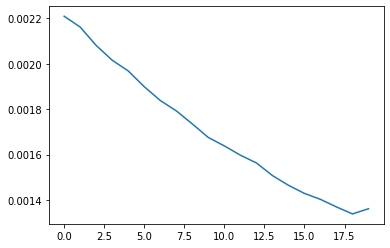

In [180]:
history = regressor.train(train_data, epochs=20, verbose=1, batch_size=np.shape(train_data.X)[0])
plt.plot(history.history['loss'])

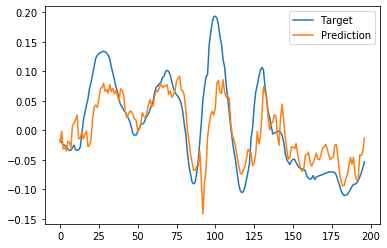

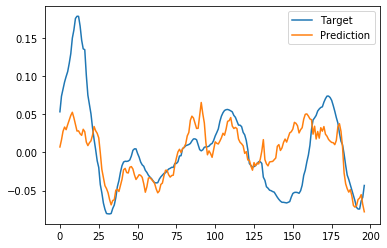

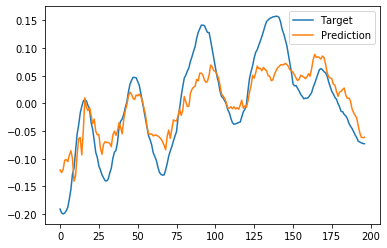

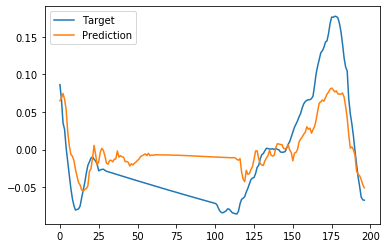

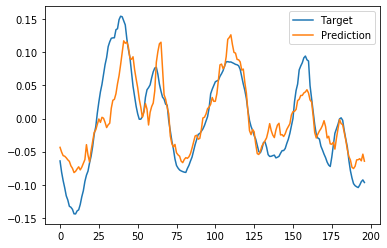

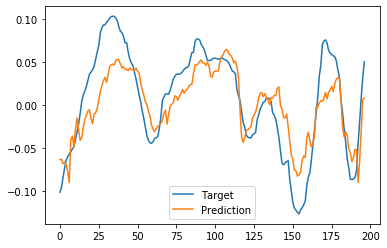

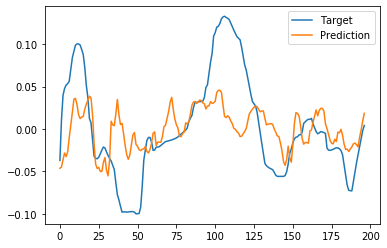

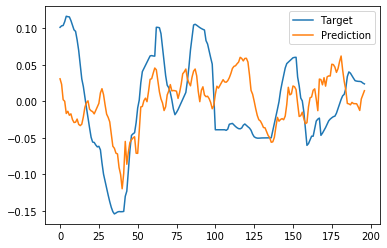

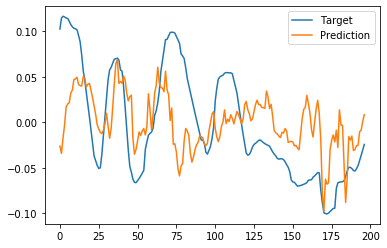

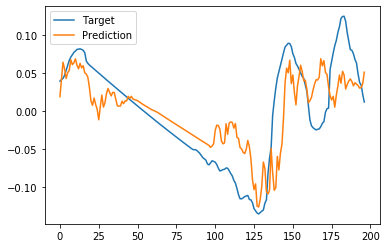

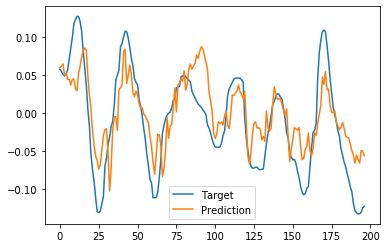

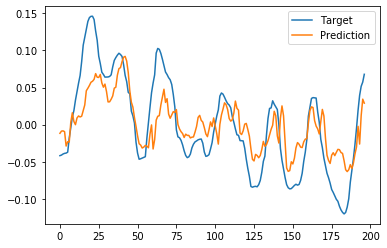

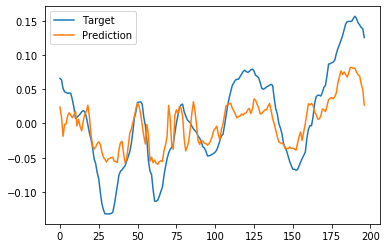

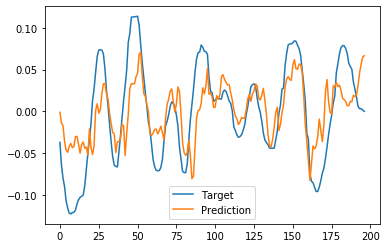

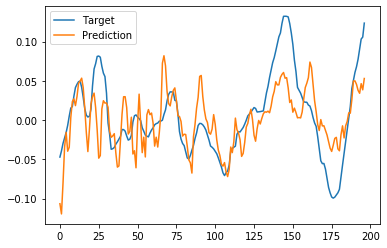

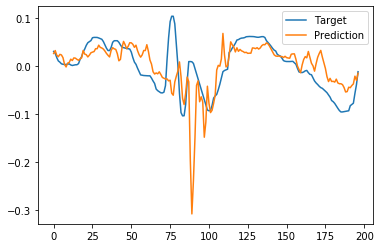

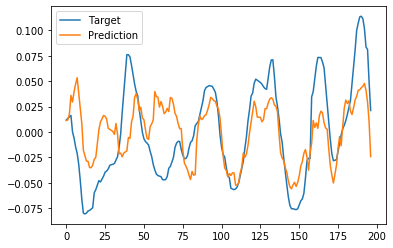

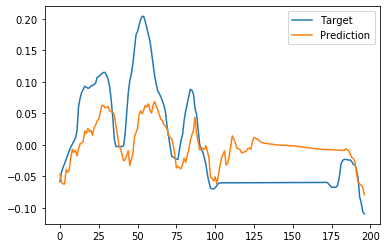

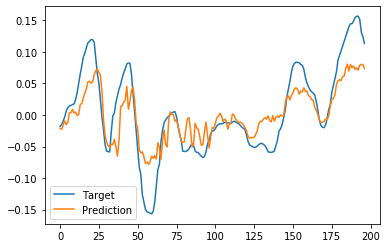

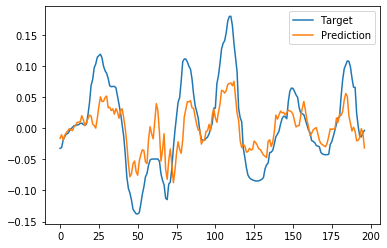

In [206]:
# data = validation_data
data = test_data

predictions = regressor.predict(data.X)
for (y_true, y_pred) in zip(data.Y, predictions):
    # y_pred = signal.savgol_filter( y_pred, window_length=11, polyorder=1, axis=0)
    # y_pred = signal.medfilt(y_pred, [5,1])
    y_pred -= np.mean(y_pred)
    y_true -= np.mean(y_true)

    # y_pred = y_pred * 1.3
    plt.plot(y_true[regressor.win_size:], label='Target')
    plt.plot(y_pred, label='Prediction')
    plt.legend()
    plt.show()

# RNN

In [ ]:
class RNN(object):
    ######################################################################################################    
    def __init__(self, win_size, Nfeatures, **params ):
        np.random.seed(7)        
        self.win_size = win_size
        self.Nfeatures = Nfeatures
        self.build_model(**params)
    ######################################################################################################
    def build_model(self, activation='softmax', optimizer='RMSprop', loss='mean_squared_error', dropout=0):        
        self.model = Sequential()           
        self.model.add( LSTM(units=20, input_shape=(self.win_size, self.Nfeatures), return_sequences=True, dropout=dropout) )    
        self.model.add( LSTM(units=10, return_sequences=True, dropout=dropout) )        
        self.model.add( LSTM(units=5, dropout=dropout) ) 
        # self.model.add( BatchNormalization() )          
        self.model.add( Dense(1, activation=activation) )                      
        self.model.compile(loss=loss, optimizer=optimizer)  
        print(self.model.summary())        
        return 
    ######################################################################################################
    def train(self, train_data, step=None, **params): 
        if step is None: step = self.win_size            
        train_data_sg = train_data.segment(self.win_size, step)
        history = self.model.fit( 
            np.concatenate( train_data_sg.X, axis=0), 
            np.concatenate( train_data_sg.Y, axis=0).reshape(-1,1), 
            **params) 
        return history
    ######################################################################################################    
    def predict(self, X, window_length=None):
        predictions = list()
        for x in X:
            pred = np.array([self.model.predict( np.reshape(x[t:t+self.win_size,:],[1,self.win_size, -1]) ) for t in range(np.shape(x)[0]-self.win_size)]).flatten()
            if window_length is not None: pred = signal.savgol_filter( pred, window_length=window_length, polyorder=1)       
            predictions.append( pred )  
        return predictions 
